최종금액 : 13709700
유닛수 : 3
주식수 : 61
종가 : 212500


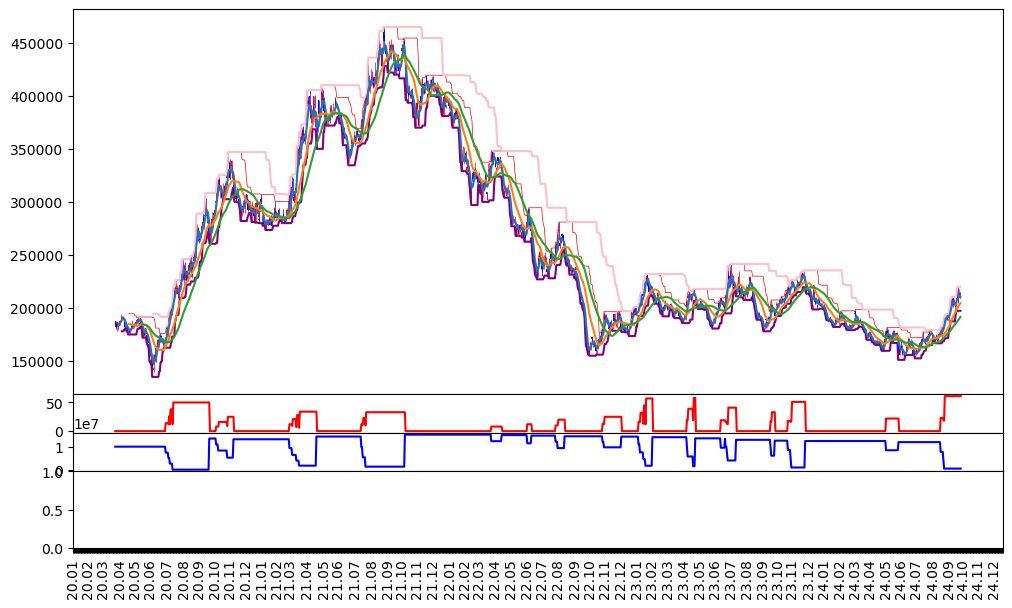

In [8]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import pandas as pd


#데이터 기간
sdate_str = '2020-01-01'
edate_str = ''


stock_code = '035420'       #종목코드
startmoney = 10000000        #시드머니
#삼성전자 005930.KS
#셀트리온 068270.KS
#LG화학 051910
#NAVER 035420
#KODEX 레버리지 122630

#주가 데이터 읽어 오기
if edate_str == '':
    f_df = fdr.DataReader(stock_code, sdate_str)
else:
    f_df = fdr.DataReader(stock_code, sdate_str, edate_str)




#20일, 55일 고가 저가의 평균
ha20 = f_df['High'].rolling(window=20).max()   #20일 최고가
la20 = f_df['Low'].rolling(window=20).min()    #20일 최저가
ha55 = f_df['High'].rolling(window=55).max()   #55일 최고가
la10 = f_df['Low'].rolling(window=10).min()    #10일 최저가


#이동평균 5, 20, 40
ma5 = f_df['Close'].rolling(window=5).mean()
ma20 = f_df['Close'].rolling(window=20).mean()
ma40 = f_df['Close'].rolling(window=40).mean()

'''
#macd
macd = f_df['Close'].rolling(window=12).mean() - f_df['Close'].rolling(window=24).mean()
macd_s = macd.rolling(window=9).mean()
'''


#고가 저가
f_df.insert(len(f_df.columns), "HA20", ha20)
f_df.insert(len(f_df.columns), "LA20", la20)
f_df.insert(len(f_df.columns), "HA55", ha55)
f_df.insert(len(f_df.columns), "LA10", la10)


f_df.insert(len(f_df.columns), "MA5", ma5)
f_df.insert(len(f_df.columns), "MA20", ma20)
f_df.insert(len(f_df.columns), "MA40", ma40)

'''
f_df.insert(len(f_df.columns), "MACD", macd)
f_df.insert(len(f_df.columns), "MACD_S", macd_s)
'''


#가중치 ATR(가격변동폭)
atr_h_c0 = f_df['High']-f_df['Close'].shift(1)  #shift(1) 아래1
atr_c0_l = f_df['Close'].shift(1)-f_df['Low']
atr_h_l = f_df['High']-f_df['Low']


#atr_df dataframe 만들기
atr_df = pd.concat([atr_h_c0, atr_c0_l, atr_h_l], axis=1)
atr_df['tr'] = atr_df.max(axis = 1)
atr_df['atr'] = atr_df['tr'].rolling(window=20).mean()
atr_df = atr_df.fillna(0)   #0으로 채우기


#mma 계산 20일 평균에서 마지막날의 가중치를 조금 더 주는 것으로 계산
#  당일ATR = (전날의 ATR * 19 + 당일의 TR) / 20
#**당일ATR = (전날의 ATR * 19 + 당일의 TR * 2) / 21
atr_mma = [0]
mma = 0
for i in range(1, len(atr_df)):
    if mma != 0:
        mma = (mma * 19 + atr_df.iloc[i]['tr']*2)/21
        atr_mma.append(mma)
        #print('%s, %f' % (atr_df.iloc[i].index, atr_mma))
    elif atr_df.iloc[i]['atr'] != 0 and mma == 0:
        mma = atr_df.iloc[i]['atr']
        atr_mma.append(mma)
        #print('%s, %f' % (atr_df.iloc[i].index, atr_mma))
    else:
        atr_mma.append(mma)

#atr_df.insert(len(atr_df.columns), "mma", atr_mma)
f_df.insert(len(f_df.columns), "atr_mma", atr_mma)




####################진입 청산

##자본금 설정
#구분, 날짜, 금액(매도해서 돈으로 만들어 지는 것은+, 매수해서 주식으로 바꾸는 것은 -)
money = [['입금', sdate_str, startmoney]]   #초기 투자금
restmoney = money[0][2]                     #예수금

#거래정보 데이터 구조
#날짜, 거래구분(매수, 매도), 거래수량, 거래단가, 예수금
stock_trade = [[sdate_str, '', 0, 0, restmoney]]

#보유주식
#주식수량, 손절선
stock = 0           #보유주식 수
salesloss = 0       #손절선
unit = 0            #유닛단위
unit_count = 0      #보유유닛 수
reverse = 0         #그래프 교차 여부
index_str = ""


#빽트레이딩
'''
- 거래 금액은 종가 금액을 기준으로 거래
- 투자급의 1%를 감당 할 수 있는 손실로 판단하고 투자 단위(UNIT)를 계산

'''
for i in range(1, len(f_df)):
    index_str = f_df.index[i].strftime("%Y.%m.%d")

    #주기 계산에 의해 데이터가 없는 20일 까지는 계산하지 않음
    if f_df.iloc[i]['LA10'] <= 0 or f_df.iloc[i]['LA20'] <= 0 or f_df.iloc[i]['atr_mma'] <= 0:
        stock_trade.append([index_str, '', stock , 0, restmoney])
        continue


    #종가
    close = f_df.iloc[i]['Close']
    unit = int( money[0][2] * 0.01 / f_df.iloc[i]['atr_mma'] )   #구매단위


    #최초진입
    if  f_df.iloc[i]['atr_mma'] !=0  and unit_count == 0 and ( close > f_df.iloc[i-1]['HA20'] or close > f_df.iloc[i-1]['HA55'] ):
        #매수
        #구매단위 구하기, 거래내역, 주식 수량 추가, 손절선 구하기, 자본금에서 돈 빼기    
        if restmoney < close*unit:     #예수금과 거래유닛 금액 비교
            #예수금이 부족하면 빈 거래 정보 넣는다.
            stock_trade.append([index_str, '', stock , 0, restmoney])
            continue
        
        restmoney = restmoney - close * unit
        stock_trade.append([index_str, '매수', unit, close, restmoney])  #거래 추가
        stock = stock + unit        #주식 보유 수량 
        unit_count = unit_count + 1 #보유 유닛 수량
        salesloss = close - 2*f_df.iloc[i]['atr_mma']   #-2ATR에 손절선 설정
        addline = close + f_df.iloc[i]['atr_mma']/2   #+ATR1/2에 추매선 설정
        money.append(['출금', index_str, (-1)*close*unit]) #금액
        continue


    #추가 진입(unit_count>0)
    if  unit_count > 0 and unit_count <= 3 and close > addline and restmoney > close*unit:
        #구매단위 구하기, 거래내역, 주식 수량 추가, 손절선 구하기, 자본금에서 돈 빼기
        restmoney = restmoney - close*unit
        stock_trade.append([index_str, '추매수', unit, close, restmoney])  #거래 추가
        stock = stock + unit        #주식 보유 수량 
        unit_count = unit_count + 1 #보유 유닛 수량
        salesloss = close - 2*f_df.iloc[i]['atr_mma']   #-2ATR에 손절선 설정
        addline = close + f_df.iloc[i]['atr_mma']/2   #+ATR1/2에 추매선 설정
        money.append(['출금', index_str, (-1)*close*unit]) #금액
        continue


    #청산 'atr_mma
    if unit_count > 0:
        if close < f_df.iloc[i-1]['LA10'] or close < f_df.iloc[i-1]['LA20'] or close < salesloss:
            if close < f_df.iloc[i]['LA10']:
                st_str = 'LA10매도'
            elif close < f_df.iloc[i]['LA20']:
                st_str = 'LA20매도'
            else:
                st_str = '손절매도'
            
            restmoney = restmoney + close * stock
            stock_trade.append([index_str, st_str, stock , close, restmoney])  #거래 추가
            money.append(['입금', index_str, close * stock]) #금액
            stock = 0           #전체 매도
            unit_count = 0      #전체 매도
            continue
    
    #빈 거래 정보 넣는다.
    stock_trade.append([index_str, '', stock , 0, restmoney])


money_df = pd.DataFrame(money, columns=['구분', 'Date', 'Money'])


stock_trade_df = pd.DataFrame(stock_trade, columns=['Date', '구분', '주식수', '단가', '통장잔고'])


print("최종금액 : %i"% int(money_df['Money'].sum()+stock*close))
print("유닛수 : %i"% unit_count)
print("주식수 : %i"% stock)
print("종가 : %i"% close)


#################################
#       차      트
##############################

plt.figure(figsize=(12,7))

from matplotlib import gridspec
gs = gridspec.GridSpec(nrows=4, ncols=1, height_ratios=[5, 0.5, 0.5, 1])

#########################
plt.subplot(gs[0])

#켄들차트
f_df['Cmap'] = f_df['Open'] - f_df['Close']
f_df['Cmap'] = f_df['Cmap'].apply(lambda x : "blue" if x > 0 else 'red')


x = list(map(lambda x: x.strftime("%y.%m.%d"), f_df.index))
plt.bar(x, height = f_df['Close']-f_df['Open'], bottom=f_df['Open'], width=1, color=f_df['Cmap'])
plt.vlines(x, f_df['High'], f_df['Low'], colors=f_df['Cmap'],linewidth=0.5)


        #plt.plot(f_df.index, f_df['Close'], label="Close")
#plt.plot(x, f_df['HA20'], label="HA20", color='purple')    #매수 매도점
plt.plot(x, f_df['HA20'], label="HA20", color='red', linewidth=0.5)
plt.plot(x, f_df['HA55'], label="HA55", color='pink')
plt.plot(x, f_df['LA10'], label="LA10", color='purple')    #매도점


plt.plot(x, f_df['MA5'], label="MA5")
plt.plot(x, f_df['MA20'], label="MA20")
plt.plot(x, f_df['MA40'], label="MA40")

#plt.legend(loc='best')
plt.xticks([])



####아래 그래프################
plt.subplot(gs[1])

#거래량 막대 그래프
#plt.bar(x, f_df['Volume'], width=0.8, color=f_df['Cmap'])
plt.plot(stock_trade_df['Date'], stock_trade_df['주식수'], label="주식수", color='red')



#통장 잔고
plt.subplot(gs[2])
plt.plot(stock_trade_df['Date'], stock_trade_df['통장잔고'], label="통장잔고", color='blue')





plt.subplot(gs[3])

#거래량 막대 그래프
#plt.bar(x, f_df['Volume'], width=0.8, color=f_df['Cmap'])
'''
#MACD
plt.plot(x, f_df['MACD'], label="MACD")
plt.plot(x, f_df['MACD_S'], label="Signal")
plt.axhline(y=0, color = 'black')
'''


## x축 값 정리
f_df['Diff'] = f_df.index.strftime("%y.%m")
f_df['Diff-if'] = f_df.duplicated(['Diff'])
#print(type(f_df['Diff'][0]))
f_df.loc[f_df['Diff-if'] == True, ['Diff']] = ''
#print (f_df)



plt.xticks(range(0, len(f_df['Diff'])), f_df['Diff'], rotation=90)



plt.subplots_adjust(wspace =0, hspace =0)
plt.show()


#Date,Open,High,Low,Close,Volume,Change,HA20,LA20,HA55,LA10,atr_mma,Cmap,Diff,Diff-if
f_df = f_df.drop(['Change', 'Diff','Diff-if'], axis=1)

#print (stock_trade_df['Date'])

stock_trade_df.index = f_df.index

f_df['stDate'] = stock_trade_df['Date']
f_df['stTrade'] = stock_trade_df['구분']
f_df['stStockVolume'] = stock_trade_df['주식수']
f_df['stUnitPrice'] = stock_trade_df['단가']
f_df['stBankBalance'] = stock_trade_df['통장잔고']

f_df.to_csv('터틀트레이딩_'+stock_code+'.csv', encoding="utf-8-sig")